## Learning rates analysis

The idea here is to calculate "learning rates" over the 2 sessions. Objective severity is the "outcome" and the changes in factor values are the "value" 

In [1]:
from groo.groo import get_root
root_dir = get_root(".root_dir_covid")

import os

print(root_dir)
import sys
print(os.path.join(root_dir, "covid-fear", "scripts"))
sys.path.append(os.path.join(root_dir, "covid-fear", "scripts"))


import numpy as np
import pandas as pd
from cov_functions import *
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings
#import itertools
warnings.filterwarnings('ignore')
from scipy.spatial.distance import correlation as Dcorr
#import bambi as bmb
import arviz as az
#import json
#import pickle
import cov_model_management as mm

# load main dataset
df = pd.read_csv(os.path.join(root_dir, "data", "full_dataset_only_complete.csv"))
df["state_severity"] = df["deaths7_norm"]


/data/drive/postdoc/Project4_covid
/data/drive/postdoc/Project4_covid/covid-fear/scripts


WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Settings

**Learning rate type (lr_type)**  

This notebook can be run either on alpha (RW learning rate) or delta (detla in a variable i.e., update)



In [2]:
lr_type  = "alpha"  #"alpha" or "delta"
lr_average_within = "median" # or "mean" # averaging of learning rates within participant
lr_adjust = "normalize" # adjustment of learning rate (see help(func[lr_type])) 

### Functions

In [3]:
# decission 
# within subject - does one take mean/median (heavy outliers!, so i'd say median) 
# data: raw/z-scored/demeaned/standardized (i'd say standardized)

def calc_alpha(df, adjust='normalize', lr_average_within='median'):  
    """Calculate Alpha
    Parameters:
    df: Input data frame with the following values
    df["p"] ... values that are being updated 
    df["o"] ... outcomes
    
    adjust: Parameter that controls any data processing
        Options: 'normalize' (default) 
                     rescale data to [0, 1] range (both outcomes and values)
                 'zscore'
                     zscore data (both outcomes and values)
                 'demean'
                     demean data (both outcomes and values)
                 'none' 
                     no processing on data
    Returns:
    int: rescorla wagner alpha

    """
    for v in ["o", "p"]:
        if adjust == "normalize":
            df[v] = (df[v] - df[v].min()) / (df[v].max() - df[v].min())
        elif adjust == "zscore":
            df[v] = (df[v] - df[v].mean()) / df[v].std()
        elif adjust == "demean":
            df[v] = df[v]-df[v].mean()
    #print(df)
    p_t = np.array(df["p"].iloc[:-1])
    p_t_plus1 = np.array(df["p"].iloc[1:])
    o_t = np.array(df["o"].iloc[1:])
    
    if lr_average_within == 'median':
        alpha = np.median((p_t_plus1 - p_t) / (o_t - p_t))
    elif lr_average_within == 'mean':
        alpha = np.mean((p_t_plus1 - p_t) / (o_t - p_t))
    return(alpha)


def calc_delta(df, adjust='normalize', lr_average_within='median'):  
    """Calculate Delta
    Parameters:
    df: Input data frame with the following values
    df["p"] ... values that are being updated 
    
    adjust: Parameter that controls any data processing
        Options: 'normalize' (default) 
                     rescale data to [0, 1] range (both outcomes and values)
                 'zscore'
                     zscore data (both outcomes and values)
                 'demean'
                     demean data (both outcomes and values)
                 'none' 
                     no processing on data
    Returns:
    int: change in prob

    """
    for v in ["p"]:
        if adjust == "normalize":
            df[v] = (df[v] - df[v].min()) / (df[v].max() - df[v].min())
        elif adjust == "zscore":
            df[v] = (df[v] - df[v].mean()) / df[v].std()
        elif adjust == "demean":
            df[v] = df[v]-df[v].mean()
    #print(df)
    p_t = np.array(df["p"].iloc[:-1])
    p_t_plus1 = np.array(df["p"].iloc[1:])
    
    if lr_average_within == 'median':
        delta = np.median(p_t_plus1 - p_t)
    elif lr_average_within == 'mean':
        delta = np.mean(p_t_plus1 - p_t)
    return(delta)



func = {'alpha':calc_alpha,
        'delta':calc_delta}


### Check the influence of different adjustments 
There are four different data manipulation versions: ["none", "normalize", "zscore", "demean"]

In [4]:
help(func[lr_type])

Help on function calc_alpha in module __main__:

calc_alpha(df, adjust='normalize', lr_average_within='median')
    Calculate Alpha
    Parameters:
    df: Input data frame with the following values
    df["p"] ... values that are being updated 
    df["o"] ... outcomes
    
    adjust: Parameter that controls any data processing
        Options: 'normalize' (default) 
                     rescale data to [0, 1] range (both outcomes and values)
                 'zscore'
                     zscore data (both outcomes and values)
                 'demean'
                     demean data (both outcomes and values)
                 'none' 
                     no processing on data
    Returns:
    int: rescorla wagner alpha



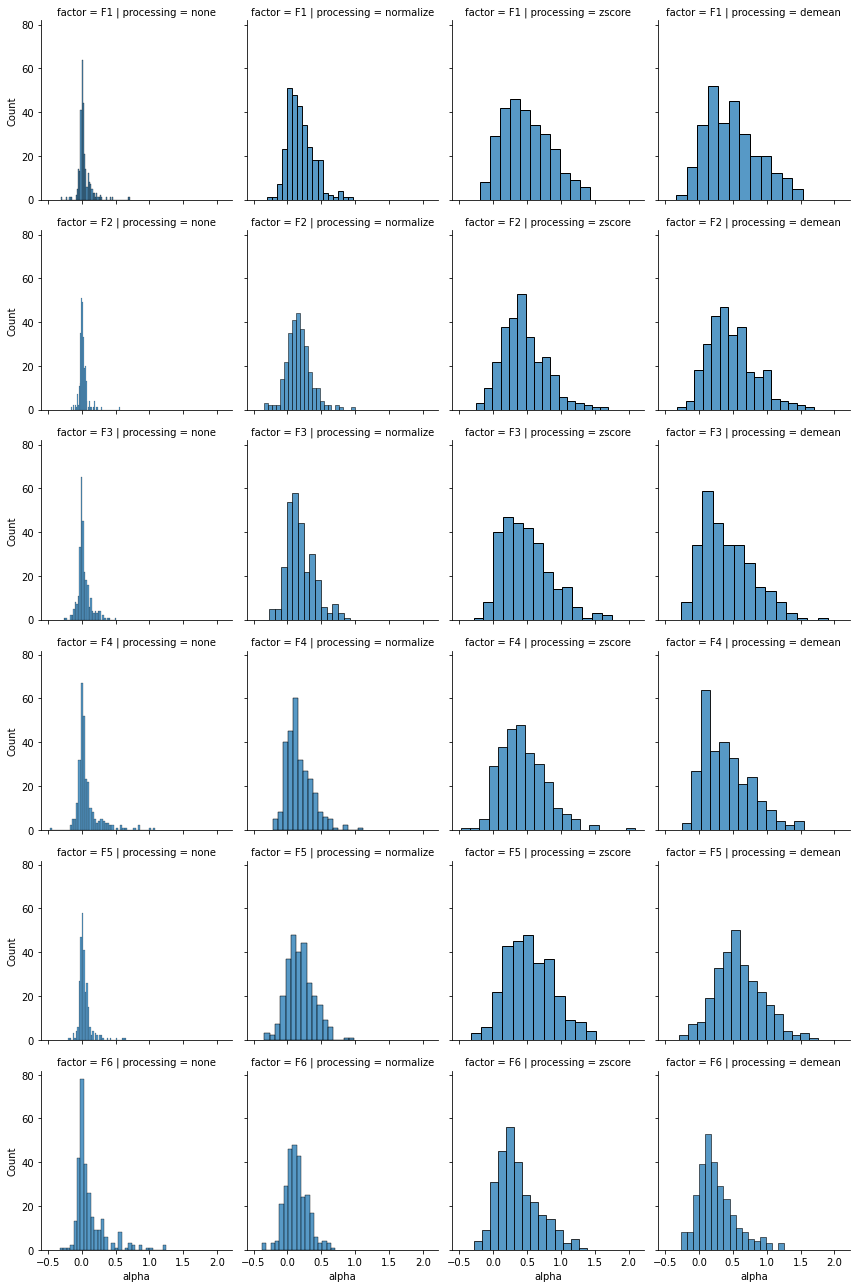

In [5]:
factors =[ "F1_Close_Person_Worry","F2_Anxiety_Avoidance", "F3_Economic_Impact_Worry", "F4_Prob_Estimates", "F5_Worry", "F6_Skepticism"]
dd = pd.DataFrame()
for f_idx,f in enumerate(factors):
    data = df.groupby(["PROLIFICID", "session"]).agg({f: "mean", "state_severity": "mean"}).reset_index() #[["PROLIFICID", "stai_ta", "bdi","cat", "sticsa_ta", "sticsa_cog_ta", "sticsa_som_ta"]].mean()
    data2=data.rename(columns={f: "p", "state_severity": "o"})
    for proc in ["none", "normalize", "zscore", "demean"]:
        tdf = pd.DataFrame()
        tdf = df.groupby(["PROLIFICID"]).agg({"state_severity": "mean"}).reset_index().set_index("PROLIFICID")
        ttdf = pd.DataFrame()
        a = data2.groupby(["PROLIFICID"]).apply(func[lr_type],  adjust=proc)
        a.replace([np.inf, -np.inf], np.nan, inplace=True)
        ttdf = pd.DataFrame(a, columns=[lr_type])
        ttdf["processing"] = proc
        ttdf["factor"] = "F"+str(f_idx+1)
        tdf = tdf.join(ttdf)
        dd = pd.concat([dd, tdf])
        
#fig = plt.figure(figsize = (16,4))
#ax = fig.gca()
#a.hist(ax = ax, bins = 100) 
dd
g = sns.FacetGrid(dd,  row="factor", col="processing")
g.map_dataframe(sns.histplot, x=lr_type)


### Build alpha data set 

In [6]:
data
data2=data.rename(columns={f: "p", "state_severity": "o"})
data2

PROLIFICID  session         p         o
0     01S0stEpc3rU6YxK        0 -0.691072  0.710526
1     01S0stEpc3rU6YxK        1 -0.805728  0.373684
2     01S0stEpc3rU6YxK        2 -0.709527  0.142105
3     01S0stEpc3rU6YxK        3 -0.737863  0.089474
4     01S0stEpc3rU6YxK        4 -0.189262  0.047368
...                ...      ...       ...       ...
5804  ztPVSoIVH3QKpGeQ       15 -0.486170  0.077612
5805  ztPVSoIVH3QKpGeQ       16 -0.421232  0.134328
5806  ztPVSoIVH3QKpGeQ       17 -0.619187  0.176119
5807  ztPVSoIVH3QKpGeQ       18 -0.561527  0.229851
5808  ztPVSoIVH3QKpGeQ       19 -0.665449  0.510448

[5809 rows x 4 columns]

In [7]:
factors =[ "covid_affective", "covid_objective"]#, "F1_Close_Person_Worry","F2_Anxiety_Avoidance", "F3_Economic_Impact_Worry", "F4_Prob_Estimates", "F5_Worry", "F6_Skepticism"]
factors_labels = ["covid aff", "covid obj"]#, "closep worry", "anx/avoid", "econ imp", "prob est", "cov worry", "skept"]
#trait_vars = ["sticsa_ta", "sticsa_cog_ta", "sticsa_som_ta", "bdi", "cat", "stai_ta"]
#trait_vars_labels = ["STICSA-TA", "STICSA-COG", "STICSA-SOM", "BDI", "Catastrophizing", "STAI-TA"]

no_trait_factors = 5

if no_trait_factors == 6:
        trait_vars = ["TF1_Self_Consciousness", "TF2_Positive", "TF3_Catastrophizing",  "TF4_Physiological_Anx",  "TF5_Depression",  "TF6_Cognitive_Anx"]
        trait_vars_labels = []
elif no_trait_factors==5:
        trait_vars = ["TF1_Worry", "TF2_Self_Worth", "TF3_Catastrophizing",  "TF4_Anxiety",  "TF5_Depression"]
        trait_vars_labels =["TF1: Worry", "TF2: Self worth", "TF3: Catastrophizing", "TF4: Anxiety", "TF5: Depression"]

#trait_vars = ["TF1_Self_Consciousness", "TF2_Tranquility", "TF3_Catastrophizing","TF4_Physiological_Anx", "TF5_Depression", "TF6_Cognitive_Anx"]
#trait_vars_labels = ["Self-Consciousness", "Tranquility", "catastrophizing", "Physio_Anxiety", "Depression", "Cogn_Anxiety"]


trait_vars_ms = [ i+"_ms" for i in trait_vars]
trait_vars_ts = [ i+"_ts" for i in trait_vars]
df_alpha = pd.DataFrame()
for f_idx,f in enumerate(factors):
    data = df.groupby(["PROLIFICID", "session", "GROUP"]+trait_vars_ms+trait_vars_ts)[["state_severity", f]+trait_vars].mean().reset_index()
    data2=data.rename(columns={f: "p", "state_severity": "o"})
    for proc in ["normalize"]:
        tdf = pd.DataFrame()
        #tdf = df.groupby(["PROLIFICID"]).agg({"state_severity": "mean"}).reset_index().set_index("PROLIFICID")
        tdf = df.groupby(["PROLIFICID", "GROUP"]+trait_vars_ms+trait_vars_ts)[["state_severity"]+trait_vars].mean().reset_index().set_index("PROLIFICID")
        ttdf = pd.DataFrame()
        a = data2.groupby(["PROLIFICID"]).apply(func[lr_type],  adjust=proc)
        a.replace([np.inf, -np.inf], np.nan, inplace=True)
        ttdf = pd.DataFrame(a, columns=[lr_type])
        ttdf["processing"] = proc
        ttdf["factor"] = factors_labels[f_idx]
        tdf = tdf.join(ttdf)
        df_alpha = pd.concat([df_alpha, tdf])

In [8]:
df_alpha

GROUP TF1_Worry_ms TF2_Self_Worth_ms TF3_Catastrophizing_ms  \
PROLIFICID                                                                     
01S0stEpc3rU6YxK    UK         high              high                   high   
05c9AaLx1V20UAcO    BE         high               low                    low   
07GDvN1Nh0oHcEBM    UK         high               low                   high   
0OjnLzK5ABd2wO54    BE          low               low                    low   
0Pe1blVigsBRLvBj    UK         high               low                   high   
...                ...          ...               ...                    ...   
zNbLeZqHa6wNHRLR    UK          low               low                    low   
zYWr4nlB9BwdVWFB    UK         high               low                   high   
zZGJnUM65XIz0F0X    UK          low               low                    low   
zlOEoLWEAwlLTGbE    UK         high              high                   high   
ztPVSoIVH3QKpGeQ    UK         high               low                    low   

                 TF4_Anxiety_ms TF5_Depression_ms TF1_Worry_ts  \
PROLIFICID                                                       
01S0stEpc3rU6YxK            low               low         high   
05c9AaLx1V20UAcO           high              high         high   
07GDvN1Nh0oHcEBM           high               low          mid   
0OjnLzK5ABd2wO54            low              high          low   
0Pe1blVigsBRLvBj           high               low          mid   
...                         ...               ...          ...   
zNbLeZqHa6wNHRLR           high               low          mid   
zYWr4nlB9BwdVWFB            low              high          mid   
zZGJnUM65XIz0F0X            low               low          mid   
zlOEoLWEAwlLTGbE           high              high          mid   
ztPVSoIVH3QKpGeQ           high               low          mid   

                 TF2_Self_Worth_ts TF3_Catastrophizing_ts TF4_Anxiety_ts  \
PROLIFICID                                                                 
01S0stEpc3rU6YxK               mid                   high            low   
05c9AaLx1V20UAcO               low                    low           high   
07GDvN1Nh0oHcEBM               mid                   high           high   
0OjnLzK5ABd2wO54               low                    mid            mid   
0Pe1blVigsBRLvBj               mid                   high           high   
...                            ...                    ...            ...   
zNbLeZqHa6wNHRLR               low                    low            mid   
zYWr4nlB9BwdVWFB               mid                    mid            low   
zZGJnUM65XIz0F0X               mid                    mid            mid   
zlOEoLWEAwlLTGbE               mid                   high           high   
ztPVSoIVH3QKpGeQ               low                    low            mid   

                 TF5_Depression_ts  state_severity  TF1_Worry  TF2_Self_Worth  \
PROLIFICID                                                                      
01S0stEpc3rU6YxK               low        0.146579   0.517251        0.024603   
05c9AaLx1V20UAcO              high        0.117866   0.625423       -1.667247   
07GDvN1Nh0oHcEBM               low        0.244821   0.106233       -0.127144   
0OjnLzK5ABd2wO54               mid        0.118383  -2.172855       -1.133754   
0Pe1blVigsBRLvBj               mid        0.158282   0.073350       -0.170443   
...                            ...             ...        ...             ...   
zNbLeZqHa6wNHRLR               low        0.162225  -0.384059       -1.460161   
zYWr4nlB9BwdVWFB              high        0.161406   0.208001       -0.224764   
zZGJnUM65XIz0F0X               low        0.150578  -0.175757       -0.557410   
zlOEoLWEAwlLTGbE              high        0.196315   0.232104        0.199069   
ztPVSoIVH3QKpGeQ               mid        0.232537   0.318578       -1.573545   

                  TF3_Catastrophizing  TF4_Anxiety  TF5_Depression     alp

['covid_affective', 'covid_objective']


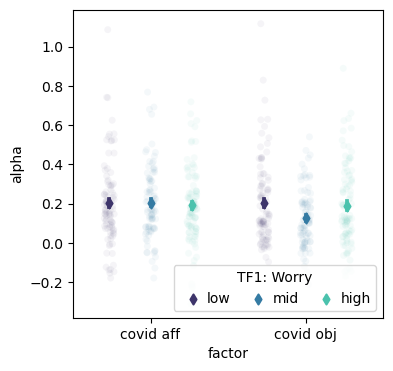

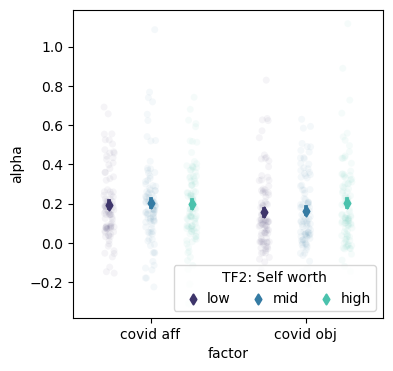

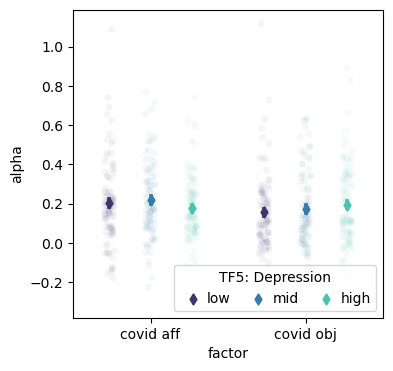

In [9]:
#for f_idx, f in enumerate(factors):
#    tdf = df_alpha.loc[df_alpha["factor"].isin(["F"+str(f_idx)]),:]
for tr_idx, tr in enumerate(trait_vars):
    plt.subplots(figsize=(4,4))
    g= sns.stripplot(x="factor", y=lr_type, hue=tr+"_ts", hue_order=["low", "mid", "high"], 
                  palette=sns.color_palette("mako",3),
                  data=df_alpha, dodge=True, alpha=.05, zorder=1)


    g = sns.pointplot(x="factor", y=lr_type, hue=tr+"_ts", hue_order=["low", "mid", "high"],
                  palette=sns.color_palette("mako",3),
                  data=df_alpha, dodge=.8 - .8 / 3,
                  join=False, 
                  markers="d", scale=.75, ci=68 )

    handles, labels = g.get_legend_handles_labels()
    g.legend(handles[3:], labels[3:], title=trait_vars_labels[tr_idx],
              handletextpad=0, columnspacing=1,
              loc="lower right", ncol=3, frameon=True)
print(factors)

In [10]:
print(df_alpha.shape)
df_alpha = df_alpha.dropna()
print(df_alpha.shape)

(602, 20)
(564, 20)


['covid_affective', 'covid_objective']


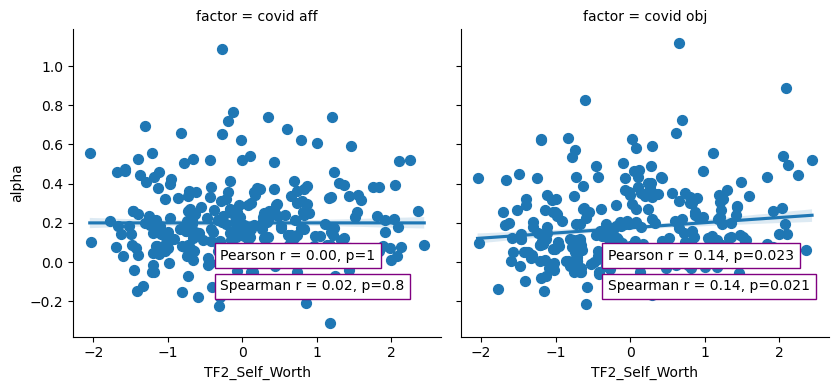

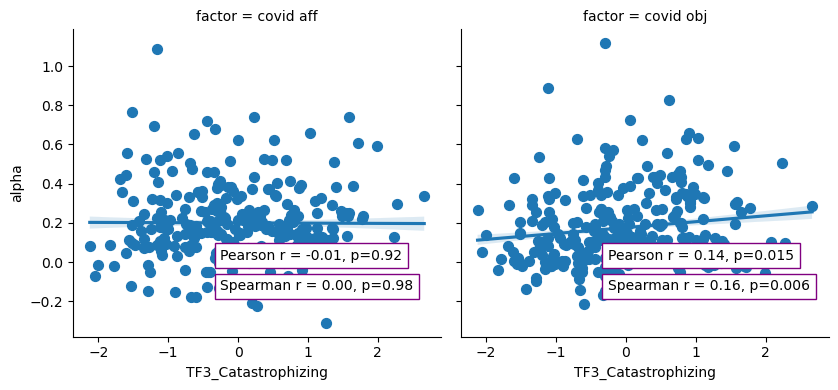

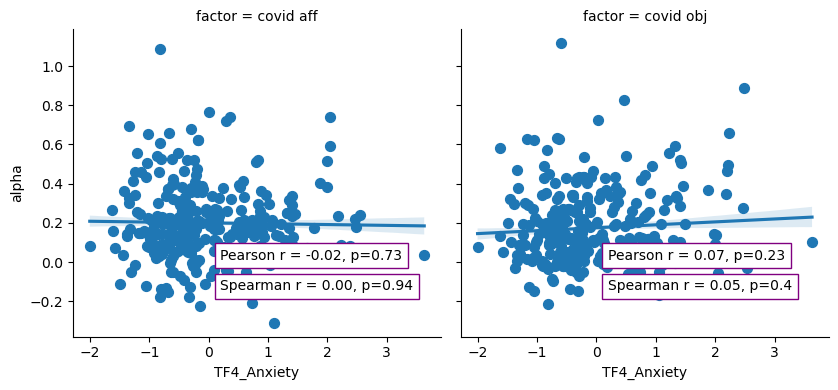

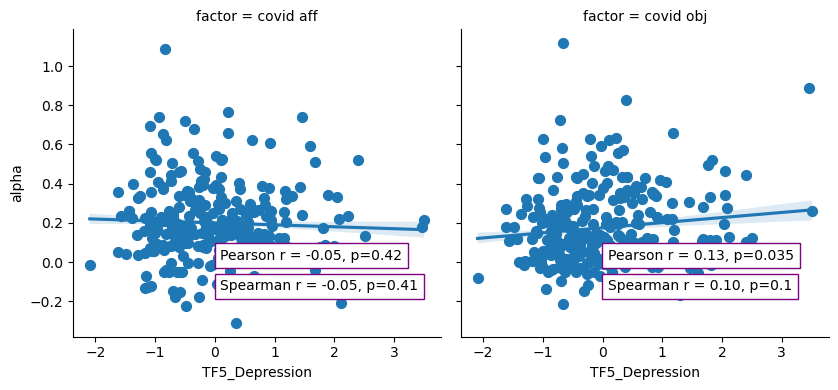

In [11]:
import seaborn as sns
import scipy as sp
for tr_idx, tr in enumerate(trait_vars):
    g = sns.lmplot(x=tr, y=lr_type, col="factor", data=df_alpha,
               col_wrap=6, ci=68, palette="muted", height=4, 
               scatter_kws={"s": 50, lr_type: 1})

    g.map(corrfunc, tr, lr_type, tests=["pearson", "spearman"])

print(factors)
